# Perkeso Data Exploration and Rough Path Signatures

### Imports

In [1]:
# Imports
random_seed = 42
import os
import pandas as pd
import numpy as np
import glob
#np.random.seed(seed = seed) 
#import random
#random.seed = seed
#import os
#os.environ['PYTHONHASHSEED'] = '0'
#from utils.utilities import *
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('ggplot')
#from scipy import stats
import tensorflow as tf
from scipy import stats
from datetime import datetime

import augment
import preprocess

import esig.tosig as ts

/home/noureddin/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def extract_sigs(data, order = 3):
    """ Extracts Signatures from each 3 consec columns of data matrix"""
    sigs = []
    for col in range(0,data.shape[1], 3):
        X = data[:,col:col+3]
        f = ts.stream2sig(X, order)
        sigs = sigs + list(f)
    
    features = ['f_'+str(i) for i in range(len(sigs))]
    sig_data = pd.DataFrame(columns=features)
    sig_data.loc[0] = sigs
    return sig_data


def extract_logsigs(data, order = 3):
    """ Extracts Log Signatures from each 3 consec columns of data matrix"""
    sigs = []
    for col in range(0,data.shape[1], 3):
        X = data[:,col:col+3]
        f = ts.stream2logsig(X, order)
        sigs = sigs + list(f)
    
    features = ['f_'+str(i) for i in range(len(sigs))]
    sig_data = pd.DataFrame(columns=features)
    sig_data.loc[0] = sigs
    return sig_data

In [3]:
#to know how many times we need to generate augmented data for each gesture
def aug_times(mov):
    a = {'0': 4, '1': 5,'2': 1, '3': 2, '4': 5, '5': 5, '6': 5, '7': 7, '8': 7}
    return a[mov]

## Load data
File name: patientid_date_label_repetitionNumber_correction_position.txt

In [4]:
def load_move_data(mov, sig_order = 3):
    # patientid_date_label_repetitionNumber_correction_position.txt
    #moves = ['0']#,'1','2','3','4','5','6','7','8']
    labels = ['1','2']
    subjects = ['104', '209', '205', '213', '303', '204', '201', '210', '211', '206', '103', '203', '305', '202', '217', '105',
     '107',  '304', '302', '212', '102', '306', '208', '214', '307', '106', '216', '215', '218', '207', '301', '101']
    #dates = ['19', '14', '12', '13', '07', '18']
    #position = ['sit', 'stand','chair','wheelchair','Stand-frame']
    data = pd.DataFrame()
    #for mov in moves:
    #print('Move: ',mov)
    for label in labels:
        #count = 0
        #print('Label: ',label)
        for subj in subjects:
            #print('Subj: ',subj)
            for file_name in glob.glob('/home/noureddin/Perkeso-Simplified/'+subj+'_*_'+mov+'_*_'+label+'_*.txt'):
                #count += 1
                tmp_df = pd.read_csv(file_name,header=None)
                tmp_df = pd.read_csv(file_name,header=None)
                   
                features = ['f_'+str(i) for i in range(tmp_df.shape[1])]
                tmp_df.columns = features
                #get a df of signatures for this episode
                #sigs = extract_sigs(tmp_df.values, order=sig_order)
                sigs = extract_logsigs(tmp_df.values, order=sig_order)
                sigs['Subject'] = subj
                #sigs['Episode'] = rep
                sigs['Original'] = 1
                sigs['Class'] = 1 if label == '1' else 0
                #print(tmp_df.shape)
                data = data.append(sigs,ignore_index=True)
                
                if label == '2':
                    #now augment data                        
                    augment_times = aug_times(mov)
                    for i in range(0,augment_times):                
                        tdata = tmp_df.values
                        #dd = DA_TimeWarp(DA_Permutation(DA_Rotation(data)))
                        dd = augment.DA_TimeWarp3(augment.DA_Rotation((tdata)))
                        sigs = extract_logsigs(dd, order=sig_order)
                        sigs['Subject'] = subj
                        #sigs['Episode'] = rep
                        sigs['Original'] = 0
                        sigs['Class'] = 1 if label == '1' else 0
                        data = data.append(sigs,ignore_index=True)
                                                        
                
                #tmp_df.columns = ['f_'+str(i) for i in range(tmp_df.shape[1])]
                #tmp_df.rename(columns={'f_75':'Original'}, inplace=True)
                
                #print(data.shape)   
    return data

In [5]:
# Test it first
data = load_move_data('6')

In [6]:
#print(data[data['Class'] == 1].shape)
#print(data[data['Class'] == 0].shape)
data.Subject.unique()

array(['104', '209', '213', '303', '204', '211', '206', '103', '305',
       '217', '105', '304', '302', '212', '102', '306', '214', '307',
       '216', '215', '301', '101', '201', '210', '207'], dtype=object)

In [35]:
data.head()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,...,f_328,f_329,f_330,f_331,f_332,f_333,f_334,f_335,f_336,f_337,f_338,f_339,f_340,f_341,f_342,f_343,f_344,f_345,f_346,f_347,f_348,f_349,Subject,Original,Class
0,-0.012914,0.005506,0.030036,0.000455,-0.000861,0.002293,4.210261e-07,-2.301914e-06,0.000015,-8.019975e-06,0.000071,-0.000025,2.870190e-05,-0.000106,-0.010211,0.005796,0.040283,0.000265,-0.000280,0.001114,2.689281e-06,-8.315025e-09,0.000009,-2.653079e-06,0.000018,...,-0.000331,-0.000216,-0.000925,0.004518,0.018750,0.002346,-0.000531,-0.010660,-0.015611,-0.086978,0.043757,-0.009592,-0.000361,0.011953,0.000022,0.000124,-0.004133,-0.003079,0.009582,0.002642,0.000335,-0.003155,104,1,1
1,0.020141,0.002413,-0.023233,-0.000023,0.000206,0.001581,-1.368478e-07,2.561361e-06,0.000002,2.436547e-05,0.000034,-0.000024,-6.267293e-06,-0.000064,0.020101,-0.001873,-0.006261,-0.000331,0.000288,0.000550,-5.349862e-06,3.408571e-06,0.000004,1.184642e-05,0.000007,...,0.000264,-0.000006,0.003794,-0.001770,0.006569,-0.003214,0.000062,-0.002753,0.011499,0.009822,-0.043553,0.003888,-0.004695,0.002215,0.000248,-0.000225,0.001109,-0.004208,0.003805,-0.002153,0.001406,-0.000158,104,1,1
2,-0.009879,0.002899,0.012958,0.000151,-0.000049,0.000769,-4.285408e-07,1.109171e-07,0.000006,-5.088378e-06,0.000023,0.000003,1.427298e-07,-0.000006,-0.002192,-0.006224,0.003651,0.000109,0.000079,0.000328,7.854777e-07,-4.272568e-08,0.000004,5.209169e-07,0.000005,...,0.000591,-0.000286,0.011828,0.001076,-0.001683,-0.010309,0.002241,-0.002022,-0.006110,-0.102288,0.001722,0.001452,-0.007698,-0.014226,0.000426,-0.000115,-0.003844,-0.001345,-0.001361,-0.000705,0.001755,0.001341,104,1,1
3,0.030345,0.005324,0.023266,-0.000568,0.000450,0.000365,-3.800516e-06,2.963112e-06,-0.000023,1.202965e-05,0.000013,0.000010,-5.395238e-06,-0.000007,0.035075,0.002550,0.018799,-0.000610,0.000527,-0.000079,-1.442373e-05,8.327437e-06,-0.000010,3.187976e-06,-0.000002,...,-0.000355,-0.000103,-0.003821,-0.000085,-0.004139,0.006531,-0.000752,-0.002375,0.058512,-0.033751,0.136092,0.000825,0.036706,-0.040401,0.000472,0.000219,0.016491,0.014742,-0.022825,0.004452,-0.003515,-0.002546,104,1,1
4,0.003274,-0.005107,-0.044084,0.000279,0.000194,0.000031,-3.063746e-06,-7.438323e-07,0.000009,-3.439650e-08,0.000002,0.000002,1.019509e-06,0.000004,0.001571,-0.005587,-0.053817,0.000109,0.000394,-0.000069,1.094241e-06,-1.798693e-06,0.000007,2.259389e-06,-0.000003,...,-0.000100,-0.000405,0.003024,0.003961,-0.006948,-0.000618,0.000718,0.004906,-0.084284,-0.106097,0.140538,0.061868,-0.000968,0.023767,0.000083,-0.000725,0.028153,0.013260,0.011115,-0.013398,0.000297,-0.006166,104,1,1


### Now Run Classifiers

In [7]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score#, classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from xgboost import XGBClassifier

moves = ['0','1','2','3','4','5','6','7','8']

subjects = ['104', '209', '205', '213', '303', '204', '201', '210', '211', '206', '103', '203', '305', '202', '217', '105', 
            '107',  '304', '302', '212', '102', '306', '208', '214', '307', '106', '216', '215', '218', '207', '301', '101']

names = ["kNN", "Gaussian Process",
         "Decision Tree", "Random Forest", #"Neural Net", 
         "AdaBoost", "Naive Bayes", "QDA", "XGB"]#, "Linear SVM", "RBF SVM"]

classifiers = [
    KNeighborsClassifier(n_neighbors=15),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(),
    RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1),
    #MLPClassifier(hidden_layer_sizes=(series_length//3,(series_length//3)//3,((series_length//3)//3)//3)),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
          max_depth = 5, alpha = 10, n_estimators = 100),
]
#    SVC(kernel="linear", C=0.025),
#    SVC(gamma=2, C=1)
#]

#names = ["RF", "KNN"]

#classifiers = [
#    RandomForestClassifier(n_estimators=500),
#    KNeighborsClassifier(n_neighbors=15)
#]

move_perf = {}

start_time = datetime.now()


for mov in moves:
    print("Move : " + mov)
    #appended_data = pd.read_csv(mov+'-logsig-3.csv')
    appended_data = load_move_data(mov)
    print("Data size: " , appended_data.shape)
    #appended_data = load_move_data(mov, sig_order=3)
    #subjects = get_subjects(mov)
    overall_results = {}
    
    for name, clf in zip(names, classifiers):
        results = []
        subj_results = {}
        for test_subj in subjects:
            #print("Testing on: " + test_subj)
            test_subject        = appended_data[appended_data['Subject'] == test_subj]
            X_test = test_subject.drop(['Subject','Class'], 1)
            y_test = test_subject['Class']

            train_subjects      = appended_data[appended_data['Subject']!= test_subj]
            X_train = train_subjects.drop(['Subject','Class'], 1)
            y_train = train_subjects['Class']
            
            #sc = StandardScaler()
            #X_train = sc.fit_transform(X_train)
            #X_test  = sc.transform (X_test)
            
            #pca = sklearnPCA(.95)
            #pca.fit(X_train)
            #X_train = pca.transform(X_train)
            #X_test = pca.transform(X_test)
            if len(X_test) > 0:
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                acc = accuracy_score(y_test.values, y_pred)
                results.append(acc)
            #print(acc)    
        overall_results[name] = results
        print("Done Clf size: " , name, np.mean(results))
    move_perf[mov] = overall_results
    #avg_acc = np.mean(results)
    #print('Avg RF Acc: ', avg_acc)

    #print('==============')

        #print(f1_score(y_test, y_pred, average="macro"))
        #print(precision_score(y_test, y_pred, average="macro"))
        #print(recall_score(y_test, y_pred, average="macro"))    
        #score = clf.score(X_test, y_test)
        #print(score)
        #print('==============')
#for k in overall_results:
#    print(k, np.mean(overall_results[k]))

print(datetime.now() - start_time)

/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Move : 0
Data size:  (438, 353)
Done Clf size:  kNN 0.9509803921568628
Done Clf size:  Gaussian Process 0.9166568461376646
Done Clf size:  Decision Tree 0.9070407096171802
Done Clf size:  Random Forest 0.8758929632459045
Done Clf size:  AdaBoost 0.9507870299635006
Done Clf size:  Naive Bayes 0.28898972922502336


/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done Clf size:  QDA 0.6697957824500024


/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

Done Clf size:  XGB 0.9099481028775146
Move : 1
Data size:  (504, 353)
Done Clf size:  kNN 0.954716056205418
Done Clf size:  Gaussian Process 0.9504911144804762
Done Clf size:  Decision Tree 0.8701116046165146
Done Clf size:  Random Forest 0.730237184165171
Done Clf size:  AdaBoost 0.8782476528139378
Done Clf size:  Naive Bayes 0.9310038641421621


/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done Clf size:  QDA 0.3307226487218304


/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

Done Clf size:  XGB 0.8704859167625124
Move : 2
Data size:  (521, 353)
Done Clf size:  kNN 0.8794312849999212
Done Clf size:  Gaussian Process 0.8600603114697206
Done Clf size:  Decision Tree 0.8196617815509148
Done Clf size:  Random Forest 0.7784143512352648
Done Clf size:  AdaBoost 0.8488595528798808
Done Clf size:  Naive Bayes 0.9088487332986293


/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done Clf size:  QDA 0.31112464614164254


/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

Done Clf size:  XGB 0.9089741010161103
Move : 3
Data size:  (527, 353)
Done Clf size:  kNN 0.9216768806287947
Done Clf size:  Gaussian Process 0.9059193093623532
Done Clf size:  Decision Tree 0.8360526758402576
Done Clf size:  Random Forest 0.6222813536188886
Done Clf size:  AdaBoost 0.8769835319088354
Done Clf size:  Naive Bayes 0.9195324650623437


/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done Clf size:  QDA 0.24754509547926914


/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

Done Clf size:  XGB 0.8826396215051678
Move : 4
Data size:  (500, 353)
Done Clf size:  kNN 0.9499231886486789
Done Clf size:  Gaussian Process 0.9346454108709011
Done Clf size:  Decision Tree 0.8367999692754594
Done Clf size:  Random Forest 0.6464057441590122
Done Clf size:  AdaBoost 0.9061712101744782
Done Clf size:  Naive Bayes 0.84799050199377


/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done Clf size:  QDA 0.3130781799899447


/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

Done Clf size:  XGB 0.9078896563373687
Move : 5
Data size:  (447, 353)
Done Clf size:  kNN 0.9643915112665111
Done Clf size:  Gaussian Process 0.9530934343434343
Done Clf size:  Decision Tree 0.9118541181041182
Done Clf size:  Random Forest 0.7962752525252524
Done Clf size:  AdaBoost 0.9206487956487955
Done Clf size:  Naive Bayes 0.8340569153069153


/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done Clf size:  QDA 0.3419216200466201


/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

Done Clf size:  XGB 0.9201048951048951
Move : 6
Data size:  (463, 353)
Done Clf size:  kNN 0.9651659340659342
Done Clf size:  Gaussian Process 0.960548717948718
Done Clf size:  Decision Tree 0.8407326451326452
Done Clf size:  Random Forest 0.7867687645687645
Done Clf size:  AdaBoost 0.9503890109890111
Done Clf size:  Naive Bayes 0.9031915750915752


/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done Clf size:  QDA 0.3043225219225219


/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

Done Clf size:  XGB 0.9233881562881564
Move : 7
Data size:  (502, 353)
Done Clf size:  kNN 0.9674277111777112
Done Clf size:  Gaussian Process 0.953553391053391
Done Clf size:  Decision Tree 0.8826505092130091
Done Clf size:  Random Forest 0.7096854534354534
Done Clf size:  AdaBoost 0.9465446012321013
Done Clf size:  Naive Bayes 0.9036321317571318


/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done Clf size:  QDA 0.30099293068043065


/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

Done Clf size:  XGB 0.9427144036519036
Move : 8
Data size:  (511, 353)
Done Clf size:  kNN 0.9669163227234608
Done Clf size:  Gaussian Process 0.9667382259664169
Done Clf size:  Decision Tree 0.8919710691036716
Done Clf size:  Random Forest 0.6852522366216127
Done Clf size:  AdaBoost 0.925836512866967
Done Clf size:  Naive Bayes 0.885872183576574


/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done Clf size:  QDA 0.42232527228491845


/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

Done Clf size:  XGB 0.9456241238842606
0:10:33.767844


/home/noureddin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [8]:
move_perf

{'0': {'kNN': [1.0,
   0.8666666666666667,
   1.0,
   1.0,
   1.0,
   0.9090909090909091,
   0.8484848484848485,
   0.8,
   1.0,
   1.0,
   1.0,
   0.9411764705882353,
   0.9,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.9090909090909091,
   1.0,
   0.8,
   1.0,
   0.8,
   1.0,
   1.0],
  'Gaussian Process': [0.8333333333333334,
   0.8,
   1.0,
   1.0,
   0.9166666666666666,
   0.9090909090909091,
   0.8787878787878788,
   0.8,
   0.9090909090909091,
   0.9583333333333334,
   1.0,
   0.9411764705882353,
   0.9,
   1.0,
   1.0,
   0.6666666666666666,
   0.9565217391304348,
   1.0,
   0.8181818181818182,
   1.0,
   0.8,
   1.0,
   0.8285714285714286,
   1.0,
   1.0],
  'Decision Tree': [1.0,
   0.8666666666666667,
   0.6666666666666666,
   1.0,
   1.0,
   0.8181818181818182,
   0.8787878787878788,
   0.84,
   1.0,
   0.9583333333333334,
   1.0,
   0.9411764705882353,
   0.9,
   1.0,
   0.9166666666666666,
   0.8333333333333334,
   1.0,
   1.0,
   0.9090909090909091,
   0.7272727272727273

In [45]:
s/9

0.9467365868748104

In [43]:
s = 0
for k in d.keys():
    print(np.mean(d[k]['kNN']))
    s += np.mean(d[k]['kNN'])

0.9509803921568628
0.954716056205418
0.8794312849999212
0.9216768806287947
0.9499231886486789
0.9643915112665111
0.9651659340659342
0.9674277111777112
0.9669163227234608


In [9]:
#move_perf
import json
with open('Perkeso-NIPS-19-move_perf.json', 'w') as outfile:
    json.dump(move_perf, outfile)

In [10]:
import json

with open('Perkeso-NIPS-19-move_perf.json') as json_file:  
    d = json.load(json_file)    

In [11]:
d

{'0': {'kNN': [1.0,
   0.8666666666666667,
   1.0,
   1.0,
   1.0,
   0.9090909090909091,
   0.8484848484848485,
   0.8,
   1.0,
   1.0,
   1.0,
   0.9411764705882353,
   0.9,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.9090909090909091,
   1.0,
   0.8,
   1.0,
   0.8,
   1.0,
   1.0],
  'Gaussian Process': [0.8333333333333334,
   0.8,
   1.0,
   1.0,
   0.9166666666666666,
   0.9090909090909091,
   0.8787878787878788,
   0.8,
   0.9090909090909091,
   0.9583333333333334,
   1.0,
   0.9411764705882353,
   0.9,
   1.0,
   1.0,
   0.6666666666666666,
   0.9565217391304348,
   1.0,
   0.8181818181818182,
   1.0,
   0.8,
   1.0,
   0.8285714285714286,
   1.0,
   1.0],
  'Decision Tree': [1.0,
   0.8666666666666667,
   0.6666666666666666,
   1.0,
   1.0,
   0.8181818181818182,
   0.8787878787878788,
   0.84,
   1.0,
   0.9583333333333334,
   1.0,
   0.9411764705882353,
   0.9,
   1.0,
   0.9166666666666666,
   0.8333333333333334,
   1.0,
   1.0,
   0.9090909090909091,
   0.7272727272727273

In [12]:
#https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# set jupyter's max row display
pd.set_option('display.max_row', 1000)

# set jupyter's max column width to 50
pd.set_option('display.max_columns', 50)



In [13]:
df = pd.DataFrame(columns=['move', 'c1', 'acc1','c2', 'acc2'])
for move, results in move_perf.items():
    print(move)
    ls = []
    for key, value in results.items():
        v = [100*d for d in value]
        #print(key, np.mean(v))
        ls.append((key, np.mean(v)))
        
    ls.sort(key=lambda x: x[1])
    (c1,acc1)=ls[-1]
    (c2,acc2)=ls[-2]
    df.loc[-1] = [move, c1, acc1, c2, acc2]  # adding a row
    df.index = df.index + 1  # shifting index
    df = df.sort_index()  # sorting by index

df = df.sort_values(by ='move' ).reset_index()

0
1
2
3
4
5
6
7
8


In [14]:
ls1 = list(df['c1'].values)
ls2 = list(df['c2'].values)

In [15]:
df

,index,move,c1,acc1,c2,acc2
0,8,0,kNN,95.098039,AdaBoost,95.078703
1,7,1,kNN,95.471606,Gaussian Process,95.049111
2,6,2,XGB,90.897410,Naive Bayes,90.884873
3,5,3,kNN,92.167688,Naive Bayes,91.953247
4,4,4,kNN,94.992319,Gaussian Process,93.464541
5,3,5,kNN,96.439151,Gaussian Process,95.309343
6,2,6,kNN,96.516593,Gaussian Process,96.054872
7,1,7,kNN,96.742771,Gaussian Process,95.355339
8,0,8,kNN,96.691632,Gaussian Process,96.673823


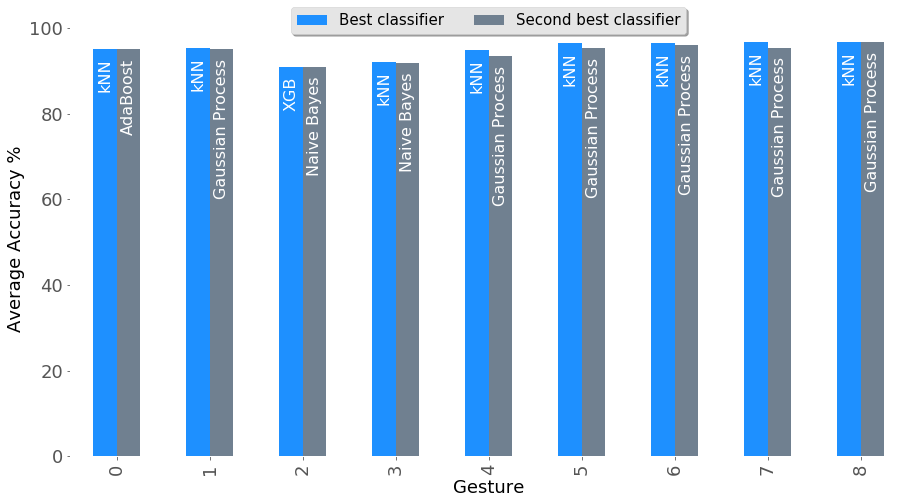

In [32]:
ax = df[['acc1', 'acc2']].plot(kind='bar', figsize=(15,8), color=['dodgerblue', 'slategray'], fontsize=18)
#ax.set_alpha(0.2)
#ax.set_title("Best two classifiers for each gesture",fontsize=18)
ax.set_ylabel("Average Accuracy %", fontsize=18, color='k')
ax.set_yticks([0, 20, 40, 60, 80, 100 ] )
ax.set_xlabel("Gesture", fontsize=18, color='k')

#ax.set_facecolor('xkcd:salmon')
ax.set_facecolor('w')
#ax.set_facecolor((0.7, 0.6, 0.42))

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=4, fancybox=True, shadow=True,fontsize=15, labels=['Best classifier','Second best classifier'])
#ax.set_xticklabels(["Robb v Joff/Tommen", "Joff/Tommen v Robb", 
#                    "Stannis v Joff/Tommen", "Robb v Joff/Tommen", 
#                    "Stannis v Mance"], rotation=0, fontsize=11)

# set individual bar lables using above list
xx = 0
label = ''
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    #print(i)
    if xx < 9:
        label = ls1[xx]
    else:
        label = ls2[xx - 9]
    xx += 1
    ax.text(i.get_x()+.05, i.get_height()-5, \
            label,  fontsize=16, color='white',
                rotation=90)